In [1]:
import pandas as pd
import pickle

# REMOVED
#import torch
#import transformers
#from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import sys
import csv
import re
from tqdm.notebook import tqdm
import sys
import csv
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from src.preprocess import *
from src.models import *
from src.lib import *

2023-08-07 23:56:42.202340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 23:56:44.816429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 23:56:44.818712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 23:56:51.038572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Explore data

### kinds of cause:
- 1 = No reason
- 2 = Bias or abuse
- 3 = Jobs and careers
- 4 = Medication
- 5 = Relationships
- 6 = Alienation

In [2]:
import numpy as np
import pandas as pd

## Training and Testing files
read_file_training = pd.read_csv('./data/added_CAMS_data.csv', encoding="ISO-8859-1")
read_file_testing = pd.read_csv('./data/IntentSDCNL_Testing.csv', encoding = "ISO-8859-1")



#training data
df_train=pd.DataFrame(read_file_training,columns= ['selftext','cause', 'inference'])### 
df_train = df_train.rename(
    columns={'selftext': 'text'})
df_train= df_train.convert_dtypes()

#testing data
df_test=pd.DataFrame(read_file_testing,columns= ['selftext','ANNOTATIONS', 'Interpretations'])#### 
df_test = df_test.rename(columns={'selftext': 'text', 'ANNOTATIONS': 'cause', 'Interpretations': 'inference'})
df_test= df_test.convert_dtypes()

## Sampling file
# df_samples=pd.read_csv('./data/sample.csv', encoding = "ISO-8859-1")

## add samples to training file

frame = [df_train]
df_train =  pd.concat(frame)

In [3]:
df_test.drop(df_test[df_test.text=="emptypost"].index, inplace=True)
df_test.drop(df_test[df_test.cause==" "].index, inplace=True)
df_test.drop(df_test[df_test.inference==" "].index, inplace=True)

# print(df_train)

df_train.drop(df_train[df_train.text=="emptypost"].index, inplace=True)
df_train.drop(df_train[df_train.cause==" "].index, inplace=True)
df_train.drop(df_train[df_train.inference==" "].index, inplace=True)

df_test.dropna(inplace=True)
df_train.dropna(inplace=True)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2877 entries, 0 to 3152
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2877 non-null   string
 1   cause      2877 non-null   Int64 
 2   inference  2877 non-null   string
dtypes: Int64(1), string(2)
memory usage: 92.7 KB


###### Class distribution of training data #####


<Axes: ylabel='count'>

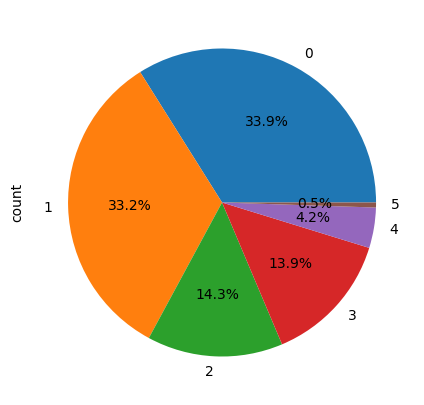

In [5]:
import matplotlib.pyplot as plt
print("###### Class distribution of training data #####")
labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_train['cause'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)


###### Class distribution of testing data #####


<Axes: ylabel='count'>

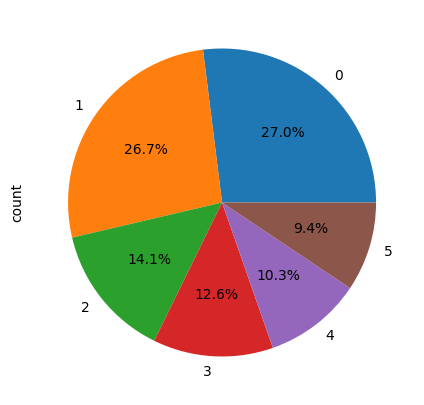

In [6]:

print("###### Class distribution of testing data #####")
labels = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(1, 1, figsize=(5,5))
df_test['cause'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)


In [7]:
df_test['cause'].value_counts()

cause
5    92
4    91
2    48
3    43
1    35
0    32
Name: count, dtype: Int64

In [8]:
frame = [df_test, df_train]
data =  pd.concat(frame)
data

,text,cause,inference
0,"Indubitably, I am not worth anything as a bein...",1,"not productive, worthless, hate, bored , issue..."
1,"Almost everyday I wake up hating myself, why w...",5,"feeling trapped, paranoid, barely talks to me,..."
2,To kill myself if im ugly?,1,ugly
3,God help me.... I know I should go to the hosp...,1,"abuse suffered, hard person to love, scars, cy..."
4,I really don't want to do anything anymore. Wh...,2,"wasting money, sulking, failure, disappointmen..."
...,...,...,...
3148,I'm sitting here just reading all your guy's a...,4,"living with grandmother to care, lost two aunt..."
3149,"Recently,I have developed a extremely annoying...",3,"cant get words out of mouth, social anxiety, m..."
3150,My depression has taken everything. I'm nearly...,5,"suffering from depression for 10 years, lost g..."
3151,"Hey guys, I'm a 22 year old male from Australi...",3,borderline personality disorder


#### A Sample

In [9]:
print_plot(df_train,0)

I look like a drug addict. I lost so much weight and I can't hold down much food without throwing up. I literally look anorexic. My eye bags are so bad too. They're so dark and deep. How can I stop these effects? My mom sees it and I don't want her to know I'm depressed. She told me I look horrible. I don't like to tell people I have depression either because knowing people they'll make me feel like my depression "isn't that bad." So I just look like a drug addict to everyone and I need this to stop. 
text: 3


## Clean and preprocess the text

####  Clean Training and Testing data

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


#training data
df_train = df_train.reset_index(drop=True)
df_train['text'] = df_train['text'].apply(clean_text)
df_train['text'] = df_train['text'].apply(clean_text)

##testing data
df_train = df_train.reset_index(drop=True)
df_test['text'] = df_test['text'].apply(clean_text)
df_test['text'] = df_test['text'].str.replace('\d+', '')

#### A sample after cleanup

In [11]:
print_plot(df_train,0)

look like drug addict lost much weight cant hold much food without throwing literally look anoreic eye bags bad theyre dark deep stop effects mom sees dont want know im depressed told look horrible dont like tell people depression either knowing people theyll make feel like depression isnt bad look like drug addict everyone need stop
text: 3


#### Intialize parameters

In [12]:
# Define some Global Variables
max_nb_words = 60000
max_features = 10543 # Maximum Number of words we want to include in our dictionary
maxlen = 500 # No of words in question we want to create a sequence with
emb_dim = 100 # Size of word to vec embedding we are usingtokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)


#### Initial Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)# tokenizer on whole training and testing data
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18102 unique tokens.


In [14]:
X_train = tokenizer.texts_to_sequences(df_train['text'].values)
X_train = pad_sequences(X_train, maxlen=maxlen)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (2877, 500)


In [15]:
Y_train = pd.get_dummies(df_train['cause']).values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (2877, 6)


In [16]:
X_test = tokenizer.texts_to_sequences(df_test['text'].values)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (341, 500)


In [17]:
Y_test = pd.get_dummies(df_test['cause']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (341, 6)


### Finally some validation data from Training Data

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,random_state=0,test_size=0.1)

In [19]:
print('TrainingData',X_train.shape,Y_train.shape)
print('TestingData',X_test.shape,Y_test.shape)
print('ValidationData',X_val.shape,Y_val.shape)


TrainingData (2589, 500) (2589, 6)
TestingData (341, 500) (341, 6)
ValidationData (288, 500) (288, 6)


In [20]:
#print a test sample
print('test example:', X_test[100])

test example: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 

In [21]:
 len(X_test[100])

500

#### Intialize Embedding

In [22]:
embedding_vectors = {}
emb_dim = 50
with open(f'./embeddings/glove.6B.{emb_dim}d.txt','r',encoding='utf-8') as file:

    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")   

Size of vocabulary in GloVe: 400000


In [23]:
#initialize the embedding_matrix with zeros

if max_nb_words is not None: 
    vocab_len = max_nb_words
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#Check some of the out of vocabulary words
print(f'A few out of valubulary words: {oov_words[0:5]}')

A few out of valubulary words: ["i'm", "don't", "i've", "it's", '\n\ni']


In [24]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

4066 out of 60000 words were OOV.


## NN models

In [25]:
##Global variables
batch_size = 256
epochs  = 20

#### a) LSTM Model

In [26]:
lstm_model = LSTM_model(embedding_matrix,vocab_len,emb_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          3000000   
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 3,092,422
Trainable params: 92,422
Non-trainable params: 3,000,000
_________________________________________________________________
None


2023-08-07 23:59:21.243911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-07 23:59:21.246760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-07 23:59:21.248231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

##### Train the model

In [27]:
%%time
history = lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

Epoch 1/20


2023-08-07 23:59:26.283569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-07 23:59:26.285738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-07 23:59:26.287639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.6542 - accuracy: 0.2758

2023-08-07 23:59:46.500793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-07 23:59:46.502816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-07 23:59:46.504258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 21s 2s/step - loss: 1.6542 - accuracy: 0.2758 - val_loss: 1.4533 - val_accuracy: 0.3750
Epoch 2/20
11/11 [==============================] - 19s 2s/step - loss: 1.4889 - accuracy: 0.3376 - val_loss: 1.4335 - val_accuracy: 0.3681
Epoch 3/20
11/11 [==============================] - 18s 2s/step - loss: 1.4637 - accuracy: 0.3747 - val_loss: 1.4230 - val_accuracy: 0.3715
Epoch 4/20
11/11 [==============================] - 19s 2s/step - loss: 1.4521 - accuracy: 0.3635 - val_loss: 1.4161 - val_accuracy: 0.3924
Epoch 5/20
11/11 [==============================] - 19s 2s/step - loss: 1.4328 - accuracy: 0.3901 - val_loss: 1.4000 - val_accuracy: 0.4201
Epoch 6/20
11/11 [==============================] - 18s 2s/step - loss: 1.4115 - accuracy: 0.4171 - val_loss: 1.4398 - val_accuracy: 0.4028
Epoch 7/20
11/11 [==============================] - 18s 2s/step - loss: 1.4000 - accuracy: 0.4253 - val_loss: 1.3340 - val_accuracy: 0.4861
Epoch 8/20
11/11 [=============

: 

: 

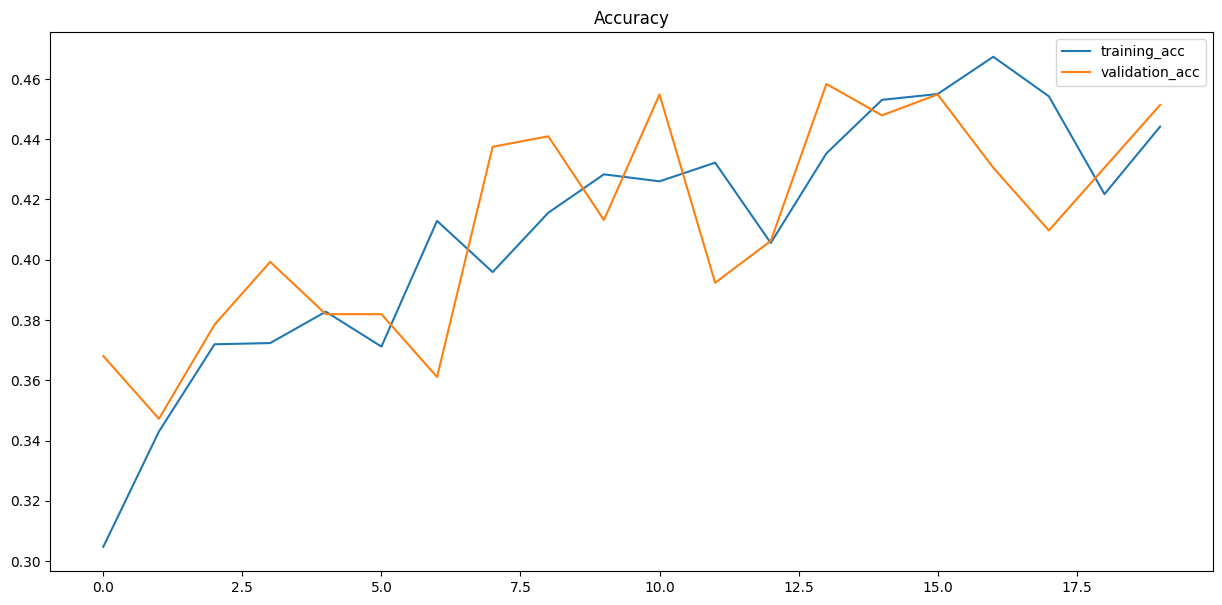

In [30]:
#plot accuracy
plot_accuracy(history,epochs)

In [31]:
# Accuracy
train_test_accuracy(lstm_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 46.00
Test accuracy: 38.12


In [32]:
#Classification report
report_nn(lstm_model,X_test,Y_test)

2023-08-06 18:29:15.758203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 18:29:15.761064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 18:29:15.763384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 2s 144ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.33      0.29      0.31        48
           3       0.24      0.19      0.21        43
           4       0.54      0.31      0.39        91
           5       0.38      0.87      0.52        92

    accuracy                           0.38       341
   macro avg       0.25      0.28      0.24       341
weighted avg       0.32      0.38      0.32       341

accuracy: 0.381


/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### b) CNN

In [33]:
cnn_model=CNN_model(embedding_matrix,vocab_len)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          3000000   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         19328     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         49280     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 6)                

##### Train the model

In [34]:
%%time
history = cnn_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),batch_size = batch_size, epochs = epochs)

Epoch 1/20
11/11 [==============================] - 6s 390ms/step - loss: 1.5856 - accuracy: 0.3272 - val_loss: 1.4254 - val_accuracy: 0.3681
Epoch 2/20
11/11 [==============================] - 4s 354ms/step - loss: 1.3991 - accuracy: 0.3955 - val_loss: 1.3695 - val_accuracy: 0.3819
Epoch 3/20
11/11 [==============================] - 4s 358ms/step - loss: 1.3290 - accuracy: 0.4511 - val_loss: 1.3284 - val_accuracy: 0.4653
Epoch 4/20
11/11 [==============================] - 4s 352ms/step - loss: 1.2660 - accuracy: 0.5110 - val_loss: 1.2936 - val_accuracy: 0.4757
Epoch 5/20
11/11 [==============================] - 4s 341ms/step - loss: 1.2074 - accuracy: 0.5396 - val_loss: 1.2767 - val_accuracy: 0.4861
Epoch 6/20
11/11 [==============================] - 4s 361ms/step - loss: 1.1640 - accuracy: 0.5751 - val_loss: 1.2413 - val_accuracy: 0.4896
Epoch 7/20
11/11 [==============================] - 4s 351ms/step - loss: 1.1035 - accuracy: 0.6022 - val_loss: 1.2246 - val_accuracy: 0.5000
Epoch 

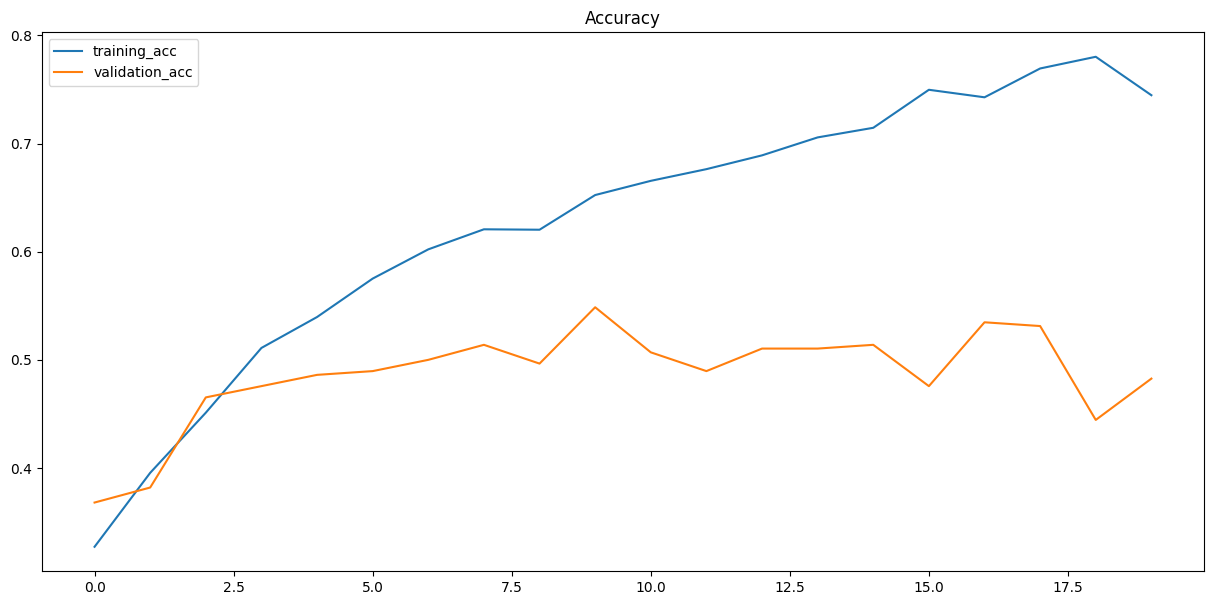

In [35]:
#plot accuracy
plot_accuracy(history,epochs)

In [36]:
# Accuracy
train_test_accuracy(cnn_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 74.04
Test accuracy: 43.70


In [37]:
#Classification report
report_nn(cnn_model,X_test,Y_test)

11/11 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.60      0.09      0.15        35
           2       0.57      0.33      0.42        48
           3       0.58      0.42      0.49        43
           4       0.68      0.33      0.44        91
           5       0.35      0.89      0.50        92

    accuracy                           0.44       341
   macro avg       0.46      0.34      0.33       341
weighted avg       0.49      0.44      0.39       341

accuracy: 0.437


/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### d) GRU

In [38]:
gru_model = GRU_model(embedding_matrix,vocab_len)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          3000000   
                                                                 
 gru (GRU)                   (None, 128)               69120     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 3,069,894
Trainable params: 69,894
Non-trainable params: 3,000,000
_________________________________________________________________


2023-08-06 18:32:59.414967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 18:32:59.416843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 18:32:59.418129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [39]:
%%time
history = gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)), batch_size = batch_size, epochs = epochs)

Epoch 1/20


2023-08-06 18:33:05.658798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 18:33:05.661442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 18:33:05.663777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.6223 - accuracy: 0.3071

2023-08-06 18:33:21.088076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 18:33:21.090454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 18:33:21.092103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 16s 1s/step - loss: 1.6223 - accuracy: 0.3071 - val_loss: 1.4668 - val_accuracy: 0.2778
Epoch 2/20
11/11 [==============================] - 13s 1s/step - loss: 1.5129 - accuracy: 0.3337 - val_loss: 1.4554 - val_accuracy: 0.3472
Epoch 3/20
11/11 [==============================] - 14s 1s/step - loss: 1.4927 - accuracy: 0.3399 - val_loss: 1.4384 - val_accuracy: 0.3264
Epoch 4/20
11/11 [==============================] - 14s 1s/step - loss: 1.4650 - accuracy: 0.3600 - val_loss: 1.4354 - val_accuracy: 0.3715
Epoch 5/20
11/11 [==============================] - 14s 1s/step - loss: 1.4532 - accuracy: 0.3727 - val_loss: 1.4299 - val_accuracy: 0.3507
Epoch 6/20
11/11 [==============================] - 14s 1s/step - loss: 1.4392 - accuracy: 0.3747 - val_loss: 1.4277 - val_accuracy: 0.3472
Epoch 7/20
11/11 [==============================] - 14s 1s/step - loss: 1.4377 - accuracy: 0.3631 - val_loss: 1.4256 - val_accuracy: 0.3472
Epoch 8/20
11/11 [=============

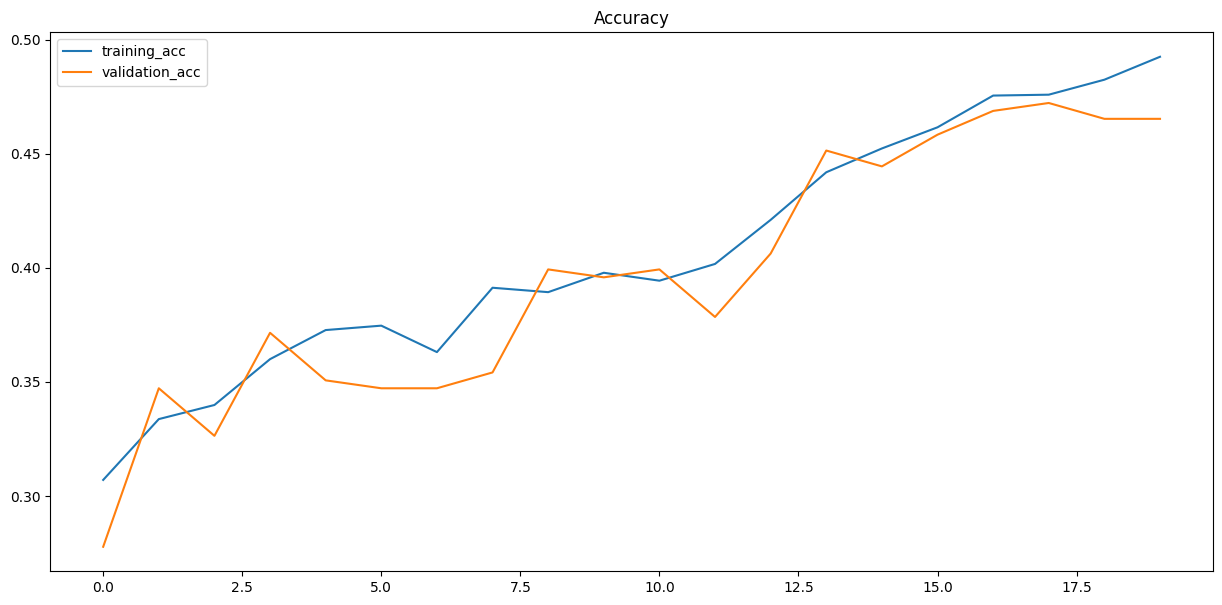

In [40]:
#plot accuracy
plot_accuracy(history,epochs)

In [41]:
# Accuracy
train_test_accuracy(gru_model,X_train,Y_train,X_test,Y_test)

Train accuracy: 50.64
Test accuracy: 40.18


In [42]:
#Classification report
report_nn(gru_model,X_test,Y_test)


 1/11 [=>............................] - ETA: 3s

2023-08-06 18:38:56.156892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 18:38:56.158659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 18:38:56.159949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 71ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        35
           2       0.50      0.25      0.33        48
           3       0.60      0.14      0.23        43
           4       0.46      0.49      0.48        91
           5       0.35      0.80      0.49        92

    accuracy                           0.40       341
   macro avg       0.32      0.28      0.25       341
weighted avg       0.36      0.40      0.34       341

accuracy: 0.402


/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python/3.8.17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### e) CNN+GRU

In [43]:
cnn_gru_model =CNN_GRU_model(embedding_matrix,vocab_len)

2023-08-06 18:39:07.262037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 18:39:07.263673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 18:39:07.265581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          9664      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 gru_1 (GRU)                 (None, None, 128)         74496     
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

/usr/local/python/3.8.17/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


: 

In [ ]:
%%time
history=cnn_gru_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(cnn_gru_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_gru_model,X_test,Y_test)

#### f) CNN+LSTM

In [ ]:
cnn_lstm_model = CNN_LSTM_model(embedding_matrix,vocab_len)

In [ ]:
%%time
history=cnn_lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history, epochs)

In [ ]:
# Accuracy
train_test_accuracy(cnn_lstm_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_lstm_model,X_test,Y_test)

##### Confusion Matrix

In [ ]:
#cnn_lstm_model0=cnn_lstm_model
print('--Confusion Matrix for CNN+LSTM--')
print_confusion(cnn_lstm_model,X_test,Y_test)

## Bidirectional LSTM models

In [ ]:
lstmbd_model = BID_LSTM_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
%%time
history=lstmbd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(cnn_lstm_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(cnn_lstm_model,X_test,Y_test)

## Bidirectional GRU

In [ ]:
grubd_model = BID_GRU_model(embedding_matrix,vocab_len,emb_dim)

In [ ]:
%%time
history=grubd_model.fit(X_train, np.asarray(Y_train), validation_data=(X_val, np.asarray(Y_val)),epochs=epochs, batch_size=batch_size)

In [ ]:
#plot accuracy
plot_accuracy(history,epochs)

In [ ]:
# Accuracy
train_test_accuracy(grubd_model,X_train,Y_train,X_test,Y_test)

In [ ]:
#Classification report
report_nn(grubd_model,X_test,Y_test)